## This book conducts language clustering on speakers in the UN OEWG meeting.
It assigns various countries to different clusters and highlights the most frequently said words by different speakers. Each cluster shows which speakers used similar languages.
This takes a csv file of different speech texts made by different countries in the UN OEWG meeting, analyses the  words often used by speakers 

In [1]:
#import needed libraries
import pandas as pd
import numpy  as np
import os
import spacy
from spacy.util import compile_infix_regex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics  import silhouette_samples, silhouette_score
from wordcloud  import WordCloud


## First Step
This step includes data cleaning and preparation.

1. Reads each csv for each meeting in each session and combines it into one dataframe

2. Remove all speech spoken by the chairman and all individual representatives

3. Ensure each country is represented with only one name. eg (the united states, US is all converted to united states)

4. Combines all the text spoken by different speakers into a single text document 

5. Merges all words with hyphen and anti

6. Removes stopwords from the text document and converts words to root words through lemmitization

7. Converting the text document to vectors and creating feature names through tf-idf vectorizer  string type to list of vectors


In [10]:
# Open the directory containing all meeting CSV files
directory = '/Users/pelumioluwaabiola/Desktop/Transcriptions/session2'

# List to store DataFrames
dfs = []

# Loop through files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read each CSV file into a DataFrame and append to the list
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame
combined_df.tail()


,Id,Session,Meeting,Speaker,Text,TextEmbeddings
9374,S4M952_7,4,9,Philippines,not be here to see us decide on something real...,"[0.02155991457402706, 0.024195637553930283, 0...."
9375,S4M952_8,4,9,Philippines,agree because we have no competence to make th...,"[0.019959090277552605, 0.05837619677186012, 0...."
9376,S4M953_1,4,9,Chairman,I thank the distinguished representative of th...,"[0.007986573502421379, 0.04187660291790962, -0..."
9377,S4M953_2,4,9,Chairman,that is not the discussion we need to have. Th...,"[0.009002426639199257, 0.04372664913535118, 0...."
9378,S4M953_3,4,9,Chairman,an expedited manner. I hope that is the case. ...,"[-0.008742045611143112, -0.03025932051241398, ..."


In [11]:
#print the combined df head
combined_df.head()

,Id,Session,Meeting,Speaker,Text,TextEmbeddings
0,S2M31_1,2,3,Chairman,"Dear colleagues, Excellencies, please take you...","[0.06515908241271973, -0.009579229168593884, 0..."
1,S2M31_2,2,3,Chairman,"we will focus. On discussions on topic 2, Curr...","[0.0666637122631073, 0.03770853951573372, 0.02..."
2,S2M31_3,2,3,Chairman,of the National Academy of Political and Strat...,"[-0.0026448278222233057, 0.117243193089962, 0...."
3,S2M32_1,2,3,The Secure World Foundation,"Thank you, Mr. Chair. My name is Victoria Samp...","[0.050753768533468246, 0.08790837973356247, 0...."
4,S2M32_2,2,3,The Secure World Foundation,to develop and promote international cooperati...,"[0.07907143235206604, -0.009904933162033558, 0..."


In [12]:
combined_df.sample(5)

,Id,Session,Meeting,Speaker,Text,TextEmbeddings
8257,S1M923_6,1,9,Iran,that they have been created for. From the disc...,"[0.021756954491138458, -0.012460146099328995, ..."
3682,S3M1038_2,3,10,China,Obviously the transparency issue is not the mo...,"[-0.0004035868914797902, 0.027517307549715042,..."
822,S2M17_48,2,1,Mr. Clinton Clark,around the sky. Next chart. So the US satellit...,"[0.04580747336149216, 0.01585925929248333, -0...."
4722,S3M257_5,3,2,Germany,issue of around the view and proximity operati...,"[0.03138783946633339, -0.04276321828365326, 0...."
1901,S2M622_34,2,6,The Russian Federation,binding instrument in order to prevent an arms...,"[0.04861760884523392, 0.009911910630762577, 0...."


In [13]:
#print unique values in the session column
combined_df['Session'].unique()

array([2, 4, 1, 3])

In [14]:
#save combined df into a csv file 
combined_df.to_csv('un_oewg_meetings.csv', index=False)

In [30]:
#remove all rows with "Chairman" in the speaker column and store in a new df
df_updated = combined_df[combined_df['Speaker'] != 'Chairman']
#get the number of rows
print(f' number of rows is {df_updated.shape[0]}')


 number of rows is 7998


In [31]:
# Print all unique values in the 'speaker' column
print(df_updated['Speaker'].unique())

['The Secure World Foundation' 'Unidir' 'Chile' 'The Russian Federation'
 'The United Kingdom' 'The United States' 'Australia' 'Germany'
 'The Australian Center for Space Governance' 'Cambodia' 'European Union'
 'Russian Federation' 'Philippines' 'Japan' 'China' 'United Kingdom'
 'France' 'Norway' 'Italy' 'Switzerland' 'The Republic of Korea' 'Canada'
 'Spain' 'Brazil' 'Dr. Suzuki' 'Mr. James Black' 'Professor Wang'
 'Mr. Clinton Clark' 'Uruguay' 'Mr. Clark' 'Professor Kazuto Suzuki'
 'Austria' 'Mr. Black' 'The Observer Research Foundation'
 'The Hillasa Center Institute of Physics of the Czech Academy of Science'
 'The Japan Space Policy at Astro Scale' 'Cuba' 'Russia'
 'The Islamic Republic of Iran' 'The Czech Academy of Science'
 '\ufeffChairman' 'Malaysia' 'Peru' 'UAE' 'Indonesia' 'Egypt' 'Thailand'
 'Turkey' 'Algeria' 'Colombia' 'Pakistan' 'Argentina' 'North Korea' 'USA'
 'South Korea' 'Belgium' 'Mexico' 'Sri Lanka' 'Sweden' 'New Zealand'
 'India' 'Ireland' 'Saudi Arabia' 'ICRC' '

In [32]:
# Delete row where 'speaker' column contains a specific string
df_updated = df_updated[df_updated['Speaker'] != '\ufeffChairman']

In [33]:
 # Delete rows where 'speaker' column containing individual representations
df_updated = df_updated[~df_updated['Speaker'].isin(['thank you, Mr. President, and thank you, dear German delegate, for this question. I hope I understood it correctly. To what extent, as far as I understand, you asked this question. The Chekhov Convention and other agreements have a position that interact and that rely on each other or are restricted from each other. This is related to understanding the articles in this agreement. I am assuming that... in order to... well, in the space agreement it is based on the usual international law and many positions coincide with the positions of other agreements and agreements. But it is a little more limited. And of course, as it is the Chekhov Convention, the right to space is based on the Chekhov Convention. Chairman'])]

In [34]:
# Delete rows where 'speaker' column containing individual representations
df_updated = df_updated[~df_updated['Speaker'].isin(['NAROOJ','Dr. Suzuki', 'Mr. James Black', 'Professor Wang' ,'Mr. Clinton Clark','Professor Kazuto Suzuki',
 'Mr. Black','Doctor Bowen', 'Doctor Gregor.', 'Mr. Stefanovich' ,'Doctor Gregor', 'Mr. Bertolotti', 'Mr. Vignetti',
 'Miss. Elena Mozarova' ,'Miss Elina Morozova', 'Mr. Lena Morozova' ,'Mr. Moto Vinati' ,'Miss Alina Morozova'
 'Mr. Mauro Vignetti', 'Mr. David Bertolotti','Doctor Bown', 'Doctor Brown', 'Mr. Dimitri Stefanovic', 'Doctor Grego' ,'Doctor. Bone', 'Mr. Stefanovic','Miss Alina Morozova' ,'Mr. Mauro Vignetti', 'Chairma', 'Dr. Suzuki' 'Mr. James Black' 'Professor Wang'
 'Mr. Clinton Clark' 'Uruguay' 'Mr. Clark' 'Professor Kazuto Suzuki','\ufeffChairman', 'Doctor Bown' 'Doctor Brown'
 'Mr. Dimitri Stefanovic' 'Doctor Grego' 'Doctor. Bone' 'Mr. Stefanovic'
 'Doctor Bowen' 'Doctor Gregor.' 'Mr. Stefanovich' 'Doctor Gregor', 'Mr. Bertolotti' 'Mr. Vignetti' 'Miss. Elena Mozarova'
 'Miss Elina Morozova' 'Mr. Lena Morozova' 'Mr. Moto Vinati'
 'Miss Alina Morozova' 'Mr. Mauro Vignetti' 'Mr. David Bertolotti','Mr. Clark'])]

In [35]:
# Print all unique values in the 'speaker' column
print(df_updated['Speaker'].unique())

['The Secure World Foundation' 'Unidir' 'Chile' 'The Russian Federation'
 'The United Kingdom' 'The United States' 'Australia' 'Germany'
 'The Australian Center for Space Governance' 'Cambodia' 'European Union'
 'Russian Federation' 'Philippines' 'Japan' 'China' 'United Kingdom'
 'France' 'Norway' 'Italy' 'Switzerland' 'The Republic of Korea' 'Canada'
 'Spain' 'Brazil' 'Uruguay' 'Austria' 'The Observer Research Foundation'
 'The Hillasa Center Institute of Physics of the Czech Academy of Science'
 'The Japan Space Policy at Astro Scale' 'Cuba' 'Russia'
 'The Islamic Republic of Iran' 'The Czech Academy of Science' 'Malaysia'
 'Peru' 'UAE' 'Indonesia' 'Egypt' 'Thailand' 'Turkey' 'Algeria' 'Colombia'
 'Pakistan' 'Argentina' 'North Korea' 'USA' 'South Korea' 'Belgium'
 'Mexico' 'Sri Lanka' 'Sweden' 'New Zealand' 'India' 'Ireland'
 'Saudi Arabia' 'ICRC' 'the Russian Federation' 'Poland' 'Netherlands'
 'Israel' 'The Islamic Republic of Iran:18' 'Portugal'
 'Philippines (Multi-Country)' 'EU'

In [41]:
# Unify Russia's name in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['Russian Federation','Russian', 'The Russian Federation','the Russian Federation'], 'Russia')

In [37]:
# Unify United States's name in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['The United States', 'USA'], 'United States')

In [38]:
# Unify United kingdom's name in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['The United Kingdom', 'UK'], 'United Kingdom')

In [39]:
# Unify Iran's name in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['The Islamic Republic of Iran', 'The Islamic Republic of Iran:18'], 'Iran')

In [43]:
# Unify UAE's name in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['United Arab Emirates', 'The United Arab Emirates'], 'UAE')

In [44]:
# Print all unique values in the 'speaker' column
print(df_updated['Speaker'].unique())

['The Secure World Foundation' 'Unidir' 'Chile' 'Russia' 'United Kingdom'
 'United States' 'Australia' 'Germany'
 'The Australian Center for Space Governance' 'Cambodia' 'European Union'
 'Philippines' 'Japan' 'China' 'France' 'Norway' 'Italy' 'Switzerland'
 'The Republic of Korea' 'Canada' 'Spain' 'Brazil' 'Uruguay' 'Austria'
 'The Observer Research Foundation'
 'The Hillasa Center Institute of Physics of the Czech Academy of Science'
 'The Japan Space Policy at Astro Scale' 'Cuba' 'Iran'
 'The Czech Academy of Science' 'Malaysia' 'Peru' 'UAE' 'Indonesia'
 'Egypt' 'Thailand' 'Turkey' 'Algeria' 'Colombia' 'Pakistan' 'Argentina'
 'North Korea' 'South Korea' 'Belgium' 'Mexico' 'Sri Lanka' 'Sweden'
 'New Zealand' 'India' 'Ireland' 'Saudi Arabia' 'ICRC' 'Poland'
 'Netherlands' 'Israel' 'Portugal' 'Philippines (Multi-Country)' 'EU'
 'Singapore' 'Venezuela' 'Hungary' 'The Russian Academy of Sciences'
 'The Massachusetts Institute of Technology' 'Secretary' 'Hong' 'French'
 'Denmark' 'Preside

In [45]:
#save all text column in a list
corpus = df_updated['Text'].tolist()
corpus[0][:100]

"Thank you, Mr. Chair. My name is Victoria Sampson and I'm the Washington Office Director for the Sec"

In [46]:
#where there '-' is an independent word, merge the word before and after it
edited_corpus = []

for document in corpus:
    words = document.split()
    merged_words = []
    i = 0
    while i < len(words):
        if words[i] == "-" and i > 0 and i < len(words) - 1:
            merged_words[-1] = merged_words[-1] + words[i + 1]
            i += 2  # Skip the next word
        else:
            merged_words.append(words[i])
            i += 1
    edited_corpus.append(' '.join(merged_words))


In [47]:
#check if '-' is a standalone word and print the word before it
for document in edited_corpus:
    words = document.split()
    for i, word in enumerate(words):
        if word == "-" and i > 0:  # Check if "-" is not the first word
            print("Word before standalone '-':", words[i - 1])

In [48]:
def merge_words_after_anti(corpus):
    merged_corpus = []
    for text in corpus:
        words = text.split()
        merged_words = []
        i = 0
        while i < len(words):
            if words[i] == 'anti' and i < len(words) - 1:
                merged_words.append( words[i] + words[i + 1])
                i += 2
            else:
                merged_words.append(words[i])
                i += 1
        merged_text = ' '.join(merged_words)
        merged_corpus.append(merged_text)
    return merged_corpus

merge_anti_corpus = merge_words_after_anti(edited_corpus)

In [49]:
#check if 'anti' is a standalone word and print the word after it
for text in merge_anti_corpus:
    words = text.split()
    for i in range(len(words) - 1):
        if words[i] == 'anti':
            print('anti', words[i + 1])

In [50]:
#print all unique words that contain 'anti'
unique_words_with_anti = set()

for text in merge_anti_corpus:
    words = text.split()
    for word in words:
        if 'anti' in word:
            unique_words_with_anti.add(word)

for word in unique_words_with_anti:
    print(word)

antispace
antiBallistic.
substantiated
Substantive
anti-space
anticipate
circumstantial
substantive.
anti-asset
anticipating
substantial
antiRussian
gigantic
substantially.
anti-aircraft
substantially
anti-aircraft,
Romantic,
quantification.
antisalad
substantial,
unsubstantiated
meantime
anticollision
antikinetic
meantime,
anticertain
Gigantic
anti-missile
unanticipated
substantial.
anti-Destructive
antisub
antimissile
anticellular
substantive
antisatellite.
substantively
anti-semitic
quantifiable
antisatellite
unsubstantive.
antisatellites
substantive...
anticipated.
anti-ballistic
granting
quantities
anti-conflict,
anticonflict
mantises
Substantively
wanting
antiballistic
anticipatory
substantive,
anti-satellite
anticipated
unsubstantiated,
anti-zetalite


In [61]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Define custom stop words
custom_stop_words = ['in', 'to', 'of', 'the', 'and', 'on', 'with', 'as', 'for', 'or', 'we','mr.', 'mr','chairman','chair', 'chairperson','thank','president','floor']

# Extend spaCy's default stop words with custom stop words
stop_words = spacy.lang.en.STOP_WORDS.union(custom_stop_words)

# Define function for lemmatization and stop word removal
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text.lower() not in stop_words and token.is_alpha]
    return " ".join(tokens)

# Process corpus in batches
batch_size = 1000
filter_corpus = []

for i in range(0, len(merge_anti_corpus), batch_size):
    batch = merge_anti_corpus[i:i+batch_size]
    processed_batch = [preprocess_text(text) for text in batch]
    filter_corpus.extend(processed_batch)

# processed_corpus now contains the preprocessed texts with custom stop words removed


In [62]:
len(filter_corpus)

7419

In [63]:
filter_corpus

['Victoria Sampson Washington Office Director Secure World Foundation Secure World Foundation private operating foundation dedicate secure sustainable use outer space benefit people Earth work government intergovernmental organization industry academia civil society develop promote international cooperation achieve secure sustainable peaceful use outer space',
 'develop promote international cooperation achieve secure sustainable peaceful use outer space delighted participate second session open end working group mandate recommendation possible norm rule principle responsible behavior relate threat state space system honor panel discuss topic current Future Earth Space threat States Space Systems today',
 'panel discuss topic current Future Earth Space threat States Space Systems today ask address following question overall trend development testing deployment direct descent antisatellite weapon type platform impact past test space environment space base activity party give time restra

In [64]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filter_corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(20, 0)

7419 rows


,0,1,2,3,4,5,6,7,8,9,...,7409,7410,7411,7412,7413,7414,7415,7416,7417,7418
secure,0.509523,0.196879,0.0,0.156948,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
foundation,0.384300,0.000000,0.0,0.157834,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sustainable,0.241255,0.186441,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
world,0.240899,0.000000,0.0,0.148408,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
washington,0.191928,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
operating,0.185873,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sampson,0.181039,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
victoria,0.181039,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
academia,0.177014,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dedicate,0.159404,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Second Step

This step includes carrying out the analysis and clustering.

1. Using K-means clustering to assign similar words to same clusters 


In [65]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [66]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [67]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instea

In [68]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

## Third Step

This step includes visualization and cluster assigning.

1. Uses a bar chat to plot the top 13 words in each cluster

2. Visualizes the top words in each cluster through word clouds

3. Assigning each speaker to a cluster based on words spoken in their speechs

4. Visualising each speaker and the clusters they are assigned to 

5. Visualizing the  result of shilouette evaluation

6. saving the final clustering dataframe into a csv file


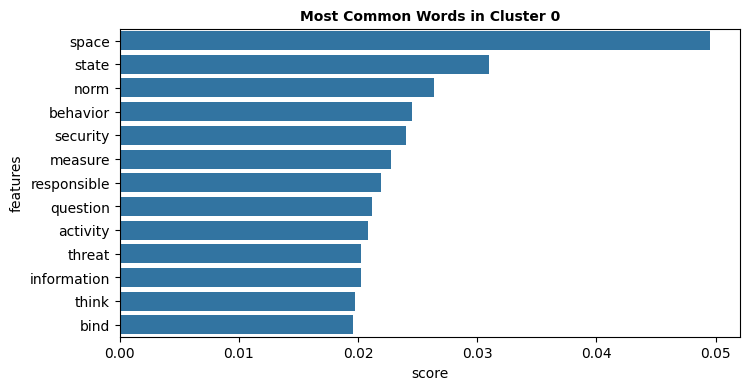

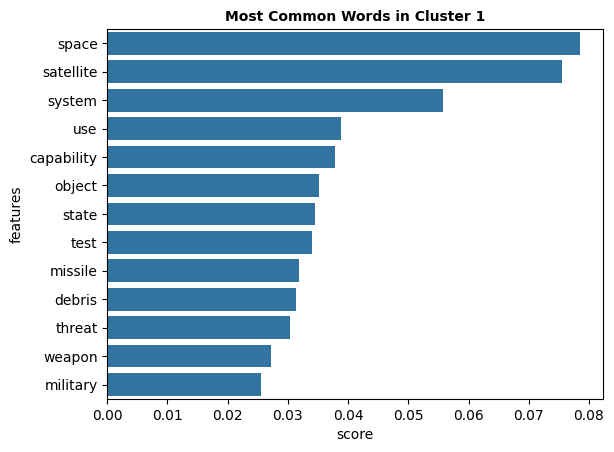

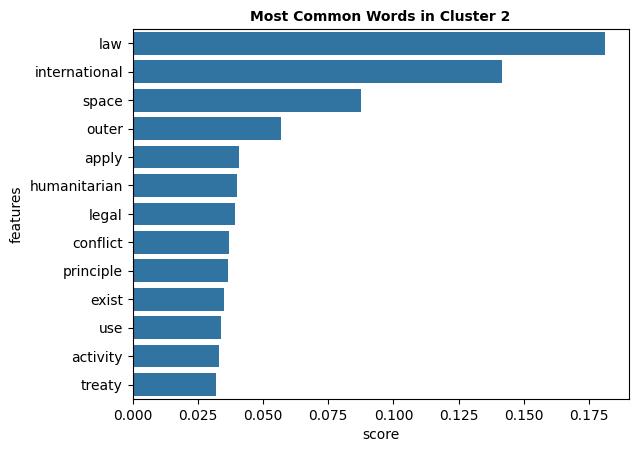

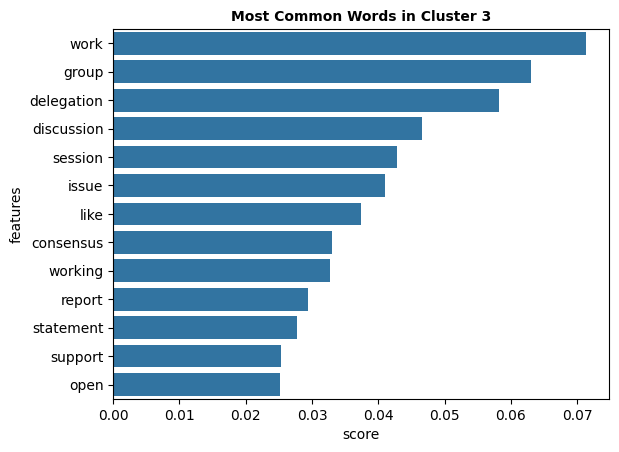

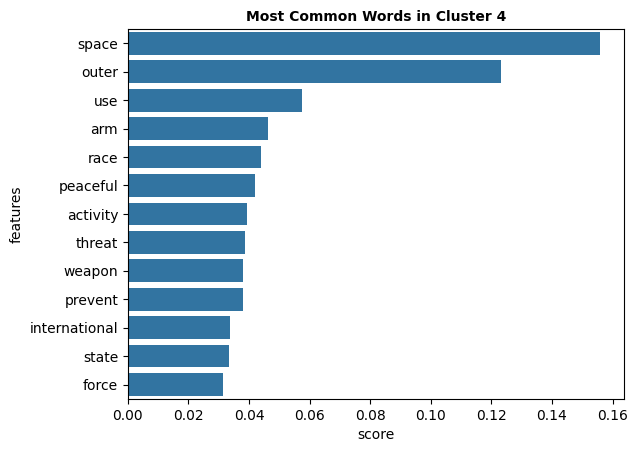

In [69]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [70]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

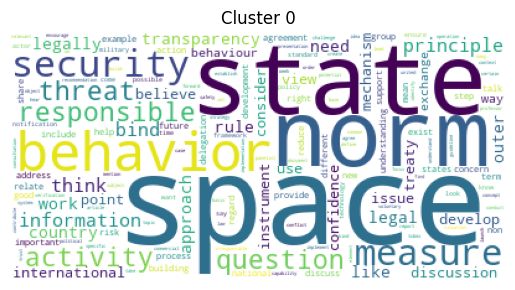

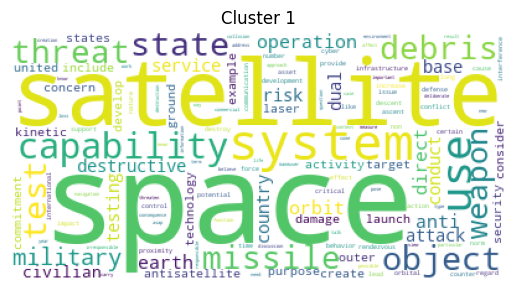

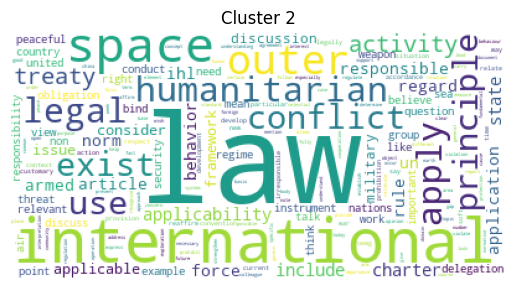

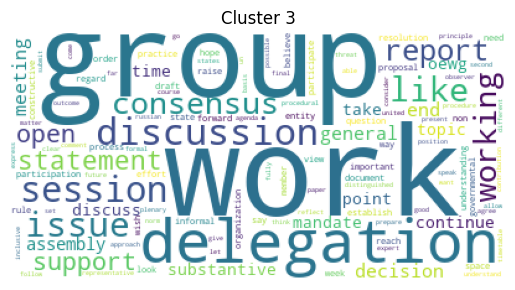

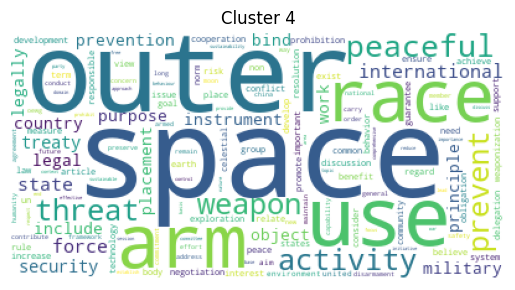

In [71]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [72]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
df_updated['Cluster'] = labels
df_updated.head()

,Id,Session,Meeting,Speaker,Text,TextEmbeddings,Cluster
3,S2M32_1,2,3,The Secure World Foundation,"Thank you, Mr. Chair. My name is Victoria Samp...","[0.050753768533468246, 0.08790837973356247, 0....",4
4,S2M32_2,2,3,The Secure World Foundation,to develop and promote international cooperati...,"[0.07907143235206604, -0.009904933162033558, 0...",4
5,S2M32_3,2,3,The Secure World Foundation,"to be here on the panel to discuss Topic 2, Cu...","[0.0647539347410202, -0.02068813517689705, 0.0...",1
6,S2M32_4,2,3,The Secure World Foundation,space environment and on the space based activ...,"[0.09294697642326355, 0.031632017344236374, 0....",1
7,S2M32_5,2,3,The Secure World Foundation,freely available to all titled. Global counter...,"[0.08138876408338547, 0.014677620492875576, 0....",1


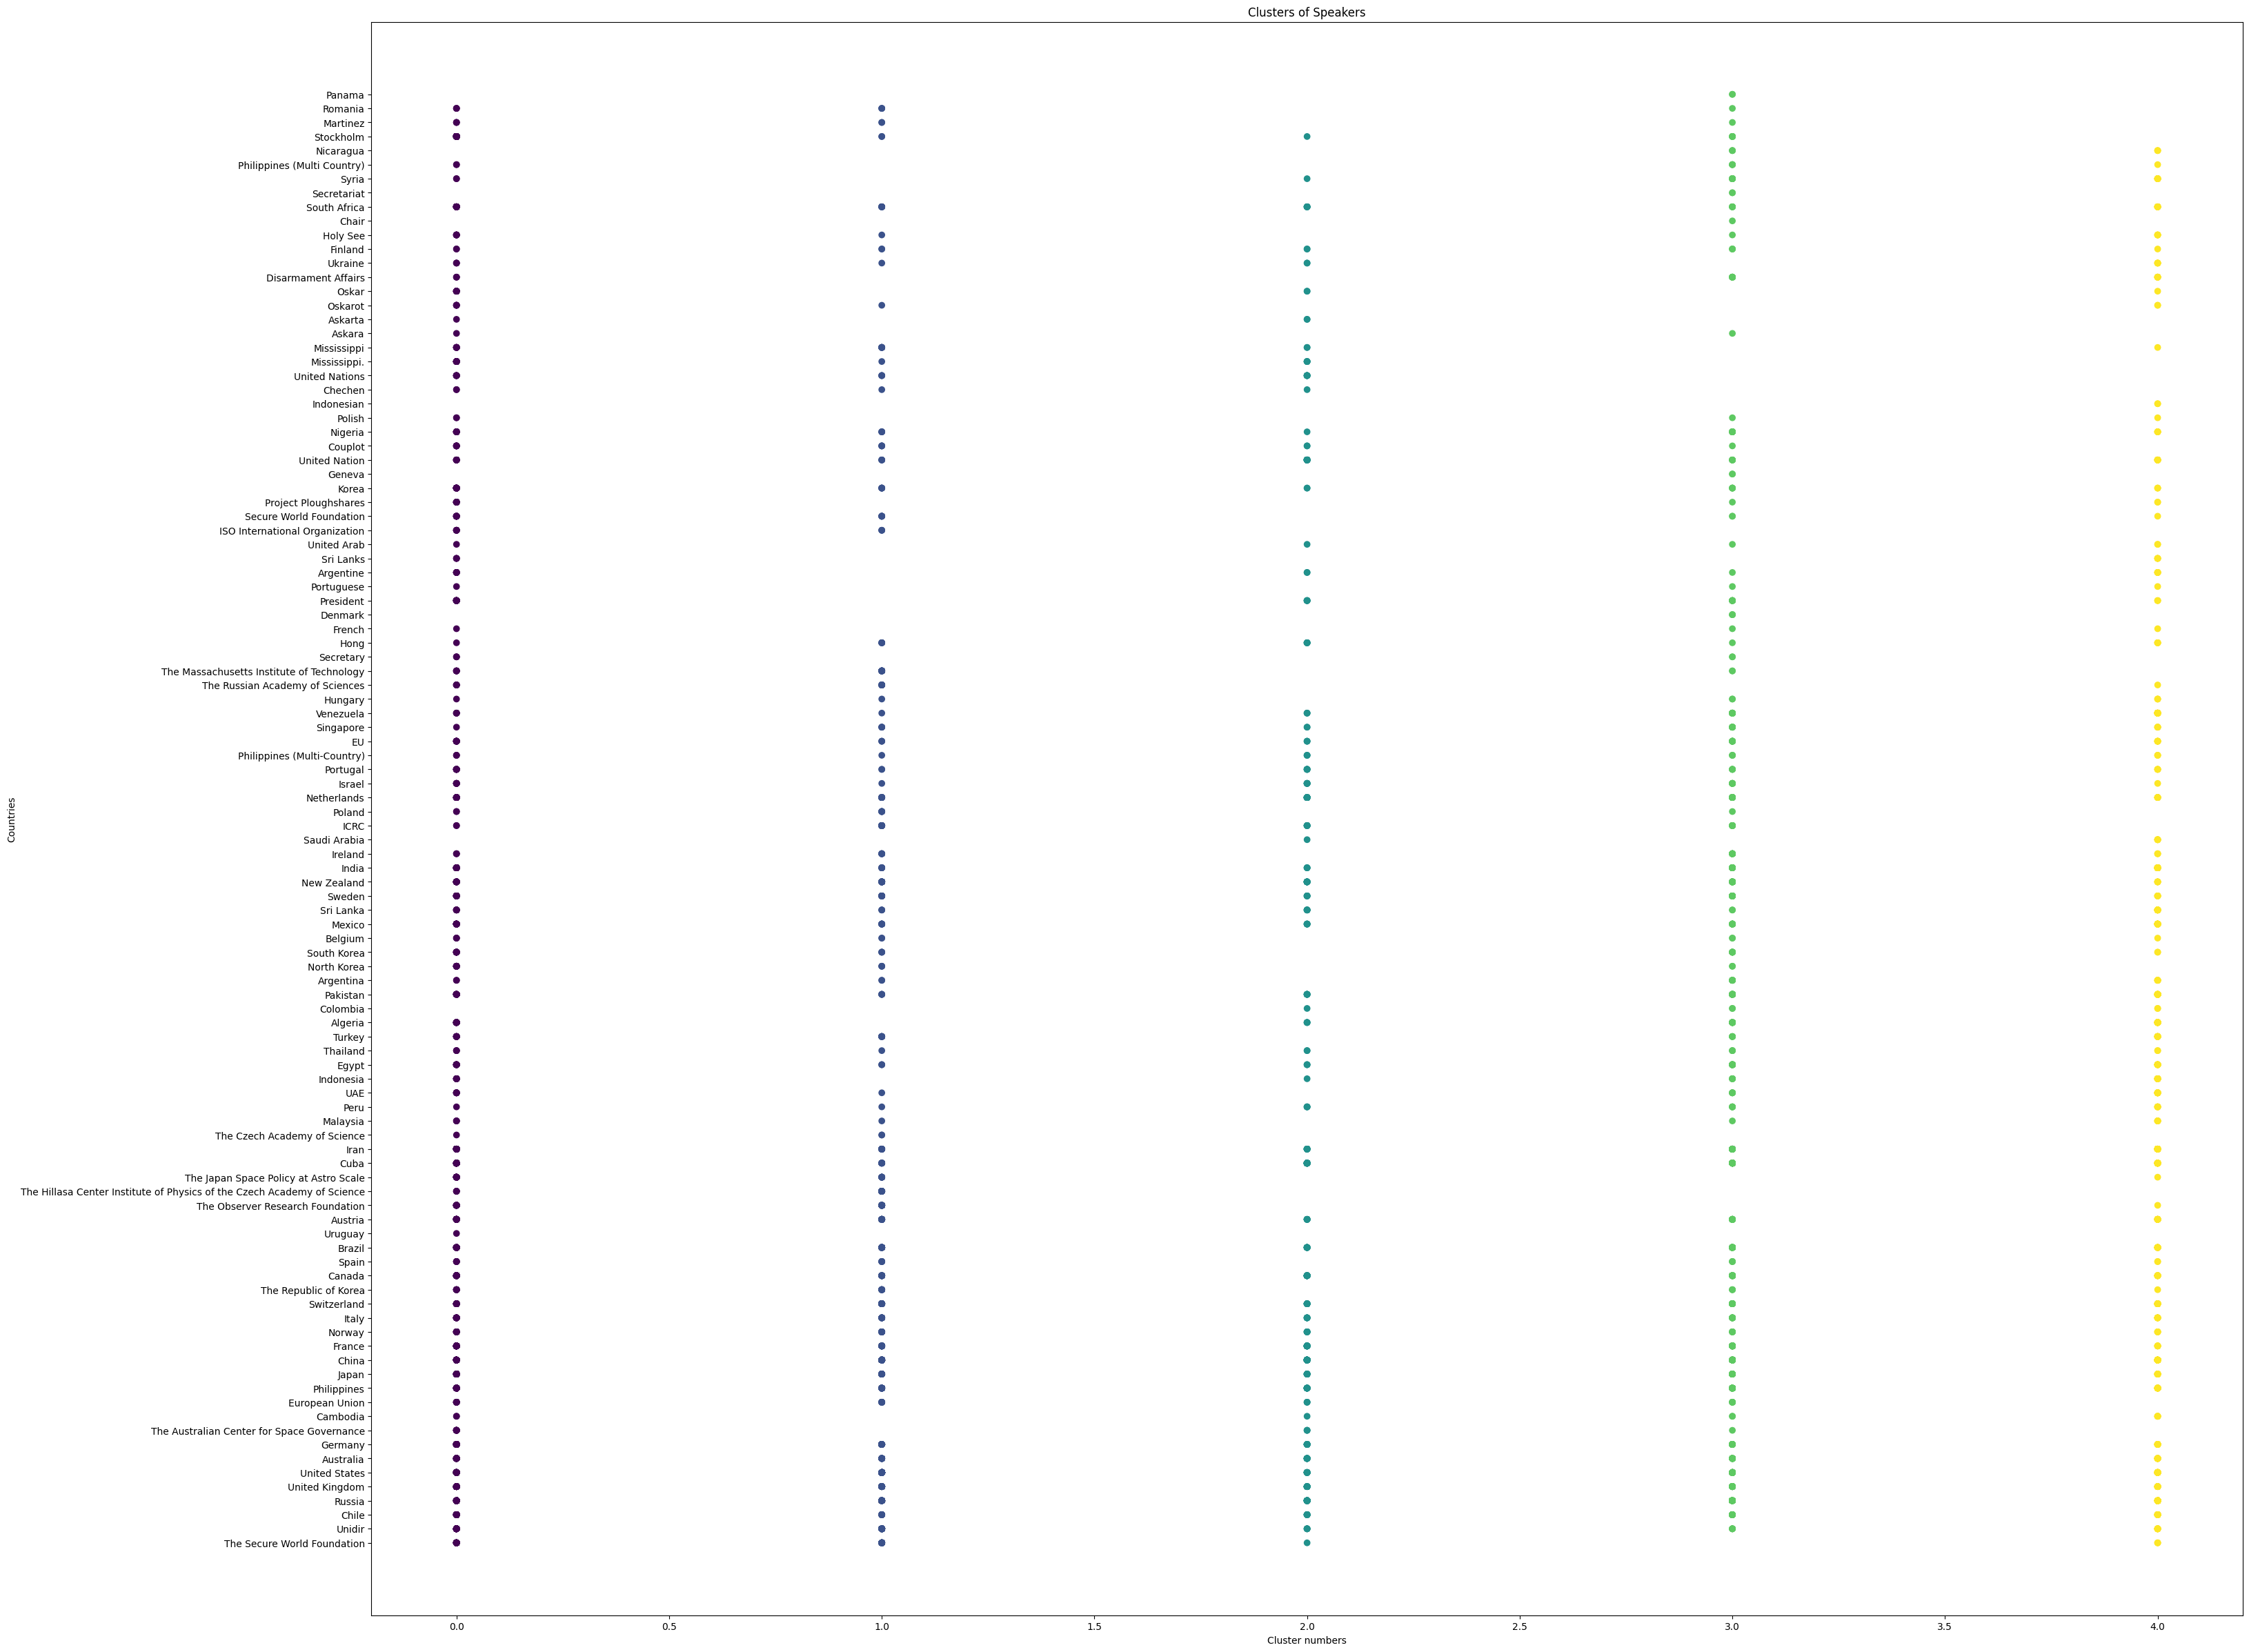

In [73]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(35, 30))
plt.scatter(df_updated['Cluster'], df_updated['Speaker'], c=df_updated['Cluster'], cmap='viridis')

# Add labels and title
plt.xlabel('Cluster numbers')
plt.ylabel('Countries')
plt.title('Clusters of Speakers')

# Show the plot
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


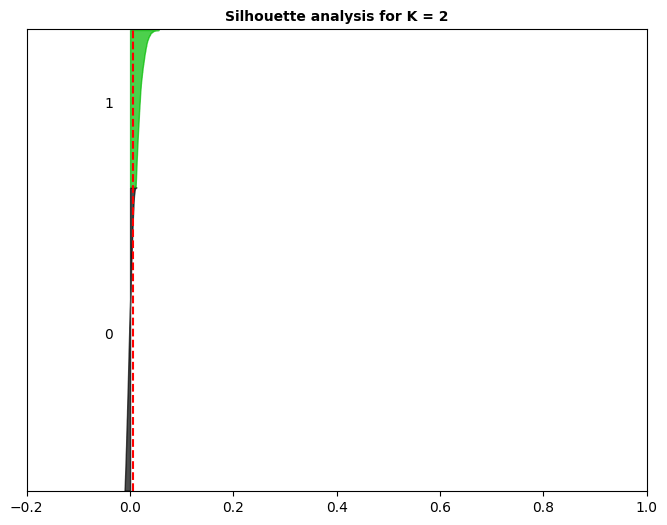

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


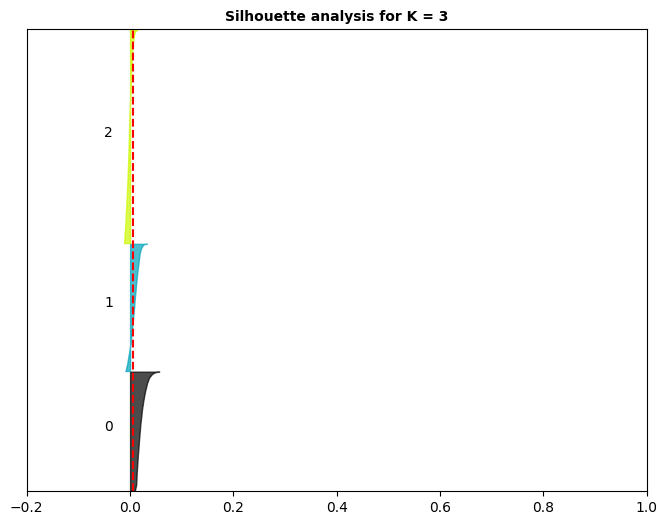

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


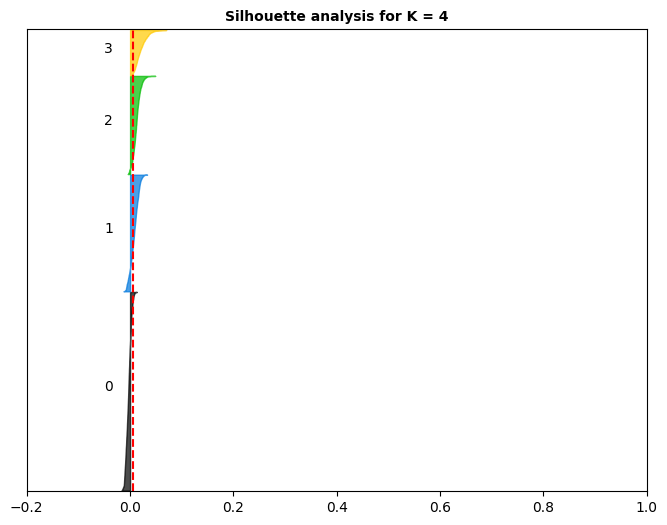

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


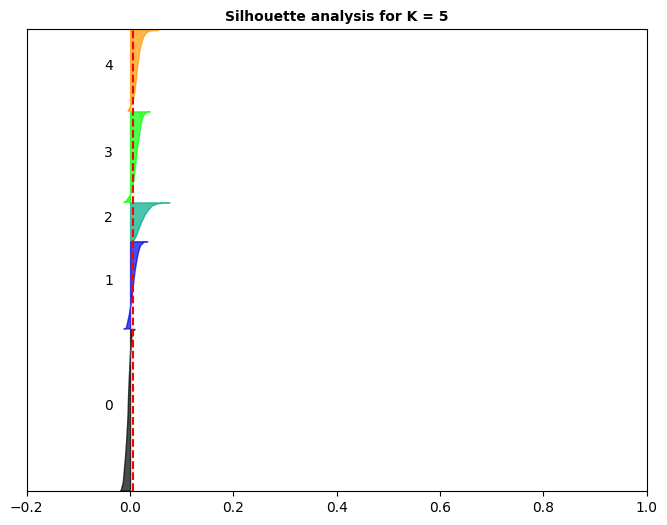

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


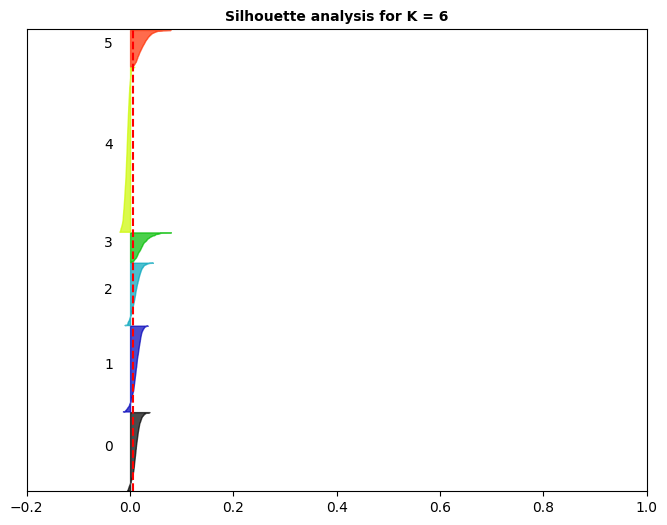

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


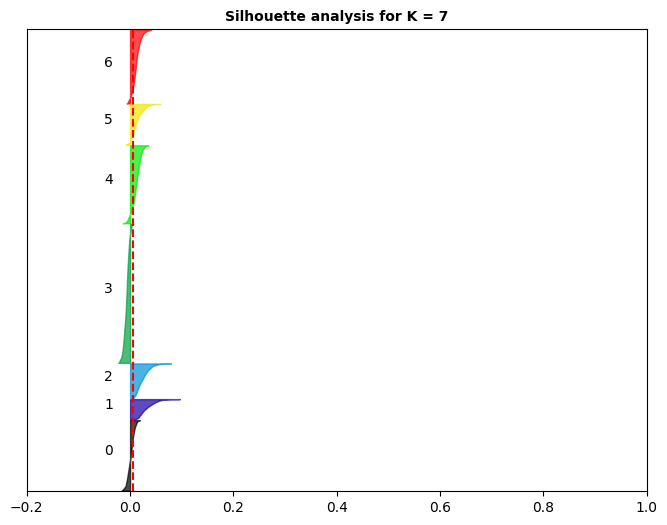

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


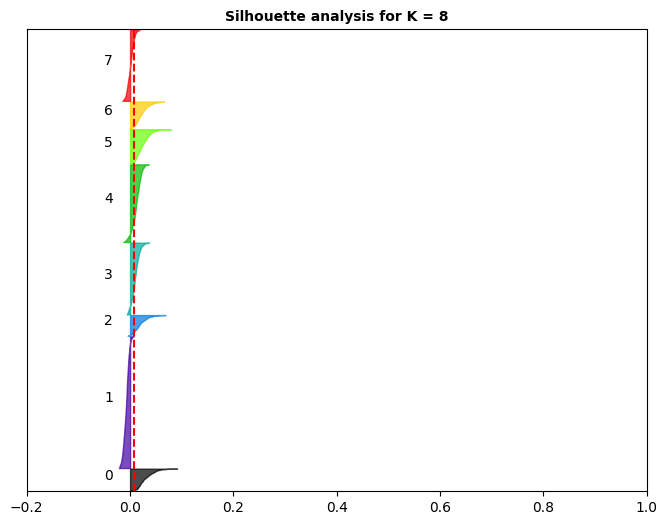

In [74]:
# Plotting Silhouette Analysis - For Evaluation
silhouette(kmeans_results, final_df, plot=True)

In [75]:
#save the df_updated into a csv file in the csv folder
df_updated.to_csv('un_oewg_meeting_language_analysis.csv', index=False)
